In [16]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.interpolate import SmoothBivariateSpline
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit as cfit
from astropy.visualization import ZScaleInterval
import stdatamodels.jwst.datamodels as dm

In [7]:
def SelectSlice(data):
    # Get vertical cross section by summing horizontally
    horiz_sum = np.mean(data,axis=1)
    horiz_err = np.std(data, axis=1)

    # Determine 3 maxima for 3 slits
    peaks = []
    j = 2
    while not len(peaks) == 3:
        if j > 6:
            break
        peaks = find_peaks_cwt(horiz_sum,j)
        j += 1
    if not len(peaks) == 3:
        return None
    # Subpixel peaks
    peaks = np.sort(getPeaksPrecise(range(len(horiz_sum)),horiz_sum,horiz_err,peaks))

    if np.any(peaks > len(horiz_sum)) or np.any(peaks < 0):
        return None

    # Cut horizontally at midpoint between maxima -> 3 strips
    slice_indices = getPeakSlice(peaks,0,len(horiz_sum),horiz_sum)

    return slice_indices


def getPeaksPrecise(x,y,err,peaks):
    try :
        coeff, err, info, msg, ier = cfit(slitletModel, x, y,sigma=err, p0=[*peaks,*y[peaks],0.5,0],full_output=True)
    except :
        print("Can't find appropriate fit. Defaulting to input")
        return peaks
    return np.array(coeff[:3])

def getPeakSlice(peaks,imin,imax,signal):
    d1 = (peaks[1] - peaks[0])/2
    d2 = (peaks[2] - peaks[1])/2

    xmin = np.array([
        smartRound(max(imin,peaks[0]-d1),signal),
        smartRound(peaks[1]-d1,signal),
        smartRound(peaks[2]-d2,signal)])

    xmax = np.array([
        smartRound(peaks[0]+d1,signal),
        smartRound(peaks[1]+d2,signal),
        smartRound(min(imax,peaks[2]+d2),signal)])

    if xmax[-1] > imax:
        xmax[-1] = imax

    return np.array([xmin,xmax]).T

def smartRound(x, signal):
    x_low = int(x)
    x_high = x_low + 1

    if x_high >= len(signal):
        return x_low

    if signal[x_low] < signal[x_high]:
        return x_low
    else:
        return x_high


def WhichShutterOpen(hdr):
    _ = hdr["SHUTSTA"]
    if _ == "11x":
        return 2
    elif _ == "1x1":
        return 1
    elif _ == "x11":
        return 0
    else:
        return None

In [8]:
working_dir = "./mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/"
path = working_dir + "jw01345063001_03101_00001_nrs2_srctype.fits"

with fits.open(path) as hdul:
        for i,hdu in enumerate(hdul):
            if not hdu.name == 'SCI':
                continue
            hdr = hdu.header
            if hdr["SOURCEID"] != 10318:
                continue

            data = np.ma.masked_invalid(hdu.data)

            shutter_id = WhichShutterOpen(hdr)
            if shutter_id is None:
                continue

            print(f"Extension {i} is SCI. Open shutter is {shutter_id+1}")

            slice_indices = SelectSlice(data)

            sliceFail = np.any(slice_indices is None)
            if sliceFail:
                print("Can't find 3 spectra. Defaulting to equal slices")
                n = data.shape[0]
                xmin = np.array([0,int(n/3),int(2*n/3)])
                xmax = np.array([int(n/3),int(2*n/3),n])
                slice_indices = np.array([xmin,xmax]).T

            bkg_slice = []
            bkg_interp = []
            coeff = []

            for j in range(2):
                # Get 2 background strips
                bkg_slice.append(data[slice_indices[shutter_id-j-1][0]:slice_indices[shutter_id-j-1][1],:])
                _ = bkg_slice[j] < 0
                bkg_slice[j][_] = np.nan
                bkg_slice[j][_].mask = True

Extension 619 is SCI. Open shutter is 2
Can't find appropriate fit. Defaulting to input


In [19]:
slits = dm.open(path)

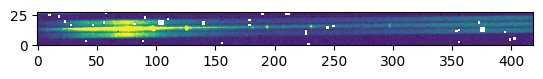

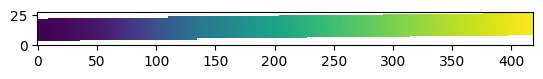

In [29]:
for slit in slits.slits:
    if slit.source_id == 10318:
        plt.figure()
        z = ZScaleInterval()
        z1,z2 = z.get_limits(slit.data)
        plt.imshow(slit.data,origin="lower",vmin=z1,vmax=z2)
        plt.show()
        
        plt.figure()
        plt.imshow(slit.wavelength,origin='lower')
        plt.show()